# Review of meta-analysis
36 meta-analysis investigating the effect of agricultural practices on sustainable water management in Europe were selected. This notebook build the figures to present the relationships between identified drivers and variables investigated in the meta-analysis and also about the quality of the selected meta-analysis.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
import numpy as np

datadir = '../'
outputdir = '../figures/'

In [2]:
# load tables from excel file
dfvar = pd.read_excel(datadir + 'CLIMASOMA meta-analysis.xlsx', sheet_name='variables')
dfvar = dfvar[dfvar['Statistical impact'].notnull()].reset_index(drop=True)
display(dfvar.tail())
dfmeta = pd.read_excel(datadir + 'CLIMASOMA meta-analysis.xlsx', sheet_name='metaAnalysis', skiprows=[0,1])

C:\Users\gblanchy\WPy64-3890\python-3.8.9.amd64\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


,Publication ID,ID,Authors,ManagementGroup,Practice,VariableGroup,Variable,Statistical impact,Assumed effect,Comment,Nb ES,Figure with ES,ES type,Number of studies,ES comment
97,xiong2018,29,"Xiong, MQ; Sun, RH; Chen, LD",Amendments,Organic amendment,Water balance,Runoff,-1.0,1,NaN,1098,yes,ratio,NaN,number of samples for runoff (but not nb of ES...
98,li2019,13,"Li, Y; Li, Z; Cui, S; Jagadamma, S; Zhang, QP",Amendments,Mulch,Hydraulic,Available water capacity,1.0,1,NaN,34,yes,ratio,264.0,n study is total not per pair (RTS + NTS + CTS...
99,li2019,13,"Li, Y; Li, Z; Cui, S; Jagadamma, S; Zhang, QP",Amendments,Mulch,Pore space,Porosity,1.0,1,NaN,86,yes,ratio,264.0,n study is total not per pair (RTS + NTS + CTS...
100,li2019,13,"Li, Y; Li, Z; Cui, S; Jagadamma, S; Zhang, QP",Amendments,Mulch,Hydraulic,Saturated hydraulic conductivity,0.0,0,NaN,10,yes,ratio,264.0,n study is total not per pair (RTS + NTS + CTS...
101,li2019,13,"Li, Y; Li, Z; Cui, S; Jagadamma, S; Zhang, QP",Amendments,Mulch,Pore space,Bulk density,-1.0,1,NaN,232,yes,ratio,264.0,n study is total not per pair (RTS + NTS + CTS...


C:\Users\gblanchy\WPy64-3890\python-3.8.9.amd64\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


## Effects of drivers on variables

In [3]:
# build matrix of effects and counts
df = dfvar
df['Nb ES'] = df['Nb ES'].fillna(0)

practices = df.sort_values(['ManagementGroup'])['Practice'].unique()
variables = df.sort_values(['VariableGroup'])['Variable'].unique().tolist()
dfeff = pd.DataFrame(columns=['practice'] + variables)
dfcount = dfeff.copy()
dfes = dfeff.copy()
for i, practice in enumerate(practices):
    dfeff.loc[i, 'practice'] = practice
    for j, variable in enumerate(variables):
        n = 0
        effect = 0
        pairs = 0
        flag = False
        for l in range(df.shape[0]):
            if (df.loc[l, 'Practice'] == practice) & (df.loc[l, 'Variable'] == variable):
                flag = True
                n += 1
                effect += df.loc[l, 'Statistical impact']
                pairs += df.loc[l, 'Nb ES']
        if flag is True:
            dfeff.loc[i, variable] = effect
        dfcount.loc[i, variable] = n
        dfes.loc[i, variable] = pairs
dfeff = dfeff.infer_objects()
dfeff.head()

,practice,Saturated hydraulic conductivity,Field capacity,Available water capacity,Wilting point,Aggregate stability,Penetration resistance,Aggregate MWD,Aggregation,Water use efficiency,Root length density,Irrigation use efficiency,Porosity,Bulk density,Macroporosity,Runoff,Water content,Infiltration,Drainage,Evaporation
0,Organic amendment,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.0,NaN,NaN,NaN,NaN
1,Mulch,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,-1.0,NaN,-3.0,NaN,1.0,NaN,-1.0
2,Biochar,0.0,1.0,2.0,1.0,1.0,NaN,NaN,1.0,1.0,NaN,NaN,2.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,Cover crop,1.0,NaN,-1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,-1.0,NaN,-4.0,-1.0,2.0,-1.0,NaN
4,Rotation,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN


In [4]:
# sorting out labelling for the graph
# based on https://stackoverflow.com/questions/20532614/multiple-lines-of-x-tick-labels-in-matplotlib
ydic = {}
for umag in df['ManagementGroup'].unique():
    ie = df['ManagementGroup'] == umag
    ydic[umag] = df[ie]['Practice'].unique().tolist()
xdic = {}
for uvar in df['VariableGroup'].unique():
    ie = df['VariableGroup'] == uvar
    xdic[uvar] = df[ie]['Variable'].unique().tolist()

xticks = []
xticklabels = []
xorder = []
xspace = []
xsep = []
c = 0
for key in ['Pore space', 'Hydraulic', 'Mechanical', 'Water balance', 'Plants']:
    vals = xdic[key]
    grouptick = c + (len(vals) - 1) / 2 + 0.01
    xticks += np.arange(c, c + len(vals)).tolist()
    c += len(vals)
    xticks += [grouptick]
    xticklabels += vals
    xticklabels += [key]
    xspace += [0] * len(vals)
    xspace += [-0.5]
    xsep += [c - 0.5]
    xorder += [np.where(np.array(variables) == a)[0][0] for a in vals]
isort = np.argsort(xticks)
xticks = np.array(xticks)[isort]
xticklabels = np.array(xticklabels)[isort]
xspace = np.array(xspace)[isort]

yticks = []
yticklabels = []
yorder = []
yspace = []
ysep = []
c = 0
for key in ['Cropping systems', 'Grazing', 'Tillage', 'Amendments', 'Irrigation']:
    vals = ydic[key]
    grouptick = c + (len(vals) - 1) / 2 + 0.01
    yticks += np.arange(c, c + len(vals)).tolist()
    yticks += [grouptick]
    c += len(vals)
    yticklabels += vals
    yticklabels += [key]
    yspace += [0] * len(vals)
    yspace += [-0.3]
    ysep += [c - 0.5]
    yorder += [np.where(np.array(practices) == a)[0][0] for a in vals]
isort = np.argsort(yticks)
yticks = np.array(yticks)[isort]
yticklabels = np.array(yticklabels)[isort]
yspace = np.array(yspace)[isort]

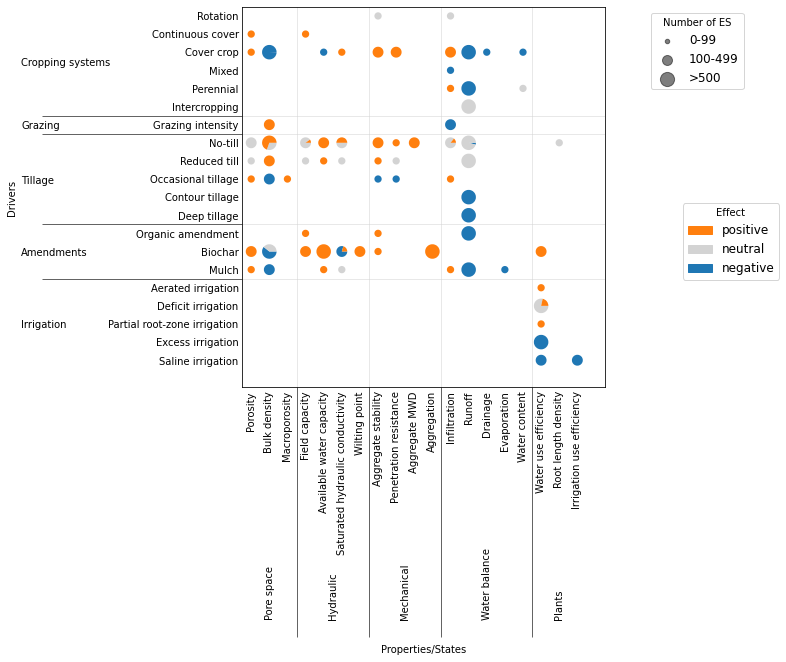

In [5]:
# figure of correlation accoring to ES size
# use wedges and class of for ES size
pracs = practices[yorder]
varias = np.array(variables)[xorder]
fig, ax = plt.subplots(figsize=(9, 7))
#dfvar['Nb ES'] = dfvar['Nb ES'].fillna(0)
colors = {1: 'tab:orange', 0: 'lightgrey', -1: 'tab:blue'}
patches = []
for i, prac in enumerate(pracs):
    for j, varia in enumerate(varias):
        ie = dfvar['Practice'].eq(prac) & dfvar['Variable'].eq(varia) & dfvar['Statistical impact'].notnull()
        if ie.sum() > 0:
            # size of the circle
            nES = dfvar[ie]['Nb ES'].sum()
            r = 0
            if nES < 100:
                r = 2
            elif nES < 500:
                r = 3
            elif nES > 500:
                r = 4
            theta1 = 0

            # section of the circle (wedges, one per statistical group)
            sdf = dfvar[ie].groupby('Statistical impact').sum().reset_index()  # group by statistical impact
            sdf['Nb ES'] = sdf['Nb ES']/sdf['Nb ES'].sum()  # proportion for each statistical impact group
            if sdf['Nb ES'].isna().sum() > 0:
                print('NaN in Nb ES column')
                print(prac, varia, sdf)
                sdf['Nb ES'] = sdf['Nb ES'].fillna(0)
            #print(prac, varia, ie.sum(), nES)
            #display(sdf[['Statistical impact', 'Nb ES']])
            for k in range(sdf.shape[0]):
                theta2 = theta1 + sdf.loc[k, 'Nb ES']*360
                #print(theta2, j, i, r, colors[sdf.loc[k, 'Statistical impact']])
                ax.add_patch(mpatches.Wedge((j, i), r*0.1, theta1, theta2, ec='none',
                                            color=colors[sdf.loc[k, 'Statistical impact']]))
                theta1 = theta2

ax.set_xlim([-0.5, len(varias)+0.5])
ax.set_ylim([-0.5, len(pracs)+0.5])
[ax.axvline(a, color='lightgrey', linewidth=0.5) for a in xsep[:-1]]
[ax.axhline(a, color='lightgrey', linewidth=0.5) for a in ysep[:-1]]
ax.set_aspect('equal')
ax.invert_yaxis()
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)
ax.set_yticks(ysep[:-1], minor=True)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=90)
ax.set_xticks(xsep[:-1], minor=True)
ax.set_xlabel('Properties/States')
ax.set_ylabel('Drivers')

for t, y in zip(ax.get_xticklabels(), xspace):
    if y != 0:
        t.set_y(y-0.1)
        t.set_va('bottom')
    else:
        t.set_y(y)
ax.tick_params(axis='x', which='minor', direction='out', length=250)
ax.tick_params(axis='x', which='major', length=0)

for t, x in zip(ax.get_yticklabels(), yspace):
    if x != 0:
        t.set_x(x-0.3)
        t.set_ha('left')
    else:
        t.set_x(x)
ax.tick_params(axis='y', which='minor', direction='out', length=200)
ax.tick_params(axis='y', which='major', length=0)

# add the legend
msizes = [100, 500, 1000]
labels = ['0-99', '100-499', '>500']
markers = []
for i, size in enumerate(msizes):
    markers.append(plt.scatter([],[], s=size*0.2, label=labels[i], color='k', alpha=0.5))
ax.add_artist(plt.legend(handles=markers, bbox_to_anchor=(1.4, 1), title='Number of ES', fontsize=12))

markers = []
markers.append(ax.add_patch(mpatches.Wedge((0,0), 0, 0, 360, color=colors[1], label='positive')))
markers.append(ax.add_patch(mpatches.Wedge((0,0), 0, 0, 360, color=colors[0], label='neutral')))
markers.append(ax.add_patch(mpatches.Wedge((0,0), 0, 0, 360, color=colors[-1], label='negative')))
ax.legend(handles=markers, bbox_to_anchor=(1.2, 0.5), title='Effect', fontsize=12)

fig.savefig(outputdir + 'impact-complex-bubble.jpg', bbox_inches='tight', dpi=500)

,driver,variable,observations,effect
0,Cover crops,Bulk density,2,neutral
1,Cover crops,Bulk density,699,beneficial
2,Cover crops,Plant available water,75,detrimental
3,Cover crops,Runoff,1398,beneficial
4,Zero or reduced tillage,Bulk density,861,detrimental
5,Zero or reduced tillage,Bulk density,303,neutral
6,Zero or reduced tillage,Plant available water,235,beneficial
7,Zero or reduced tillage,Runoff,2338,neutral
8,Zero or reduced tillage,Runoff,55,beneficial
9,Organic amendments,Bulk density,298,neutral


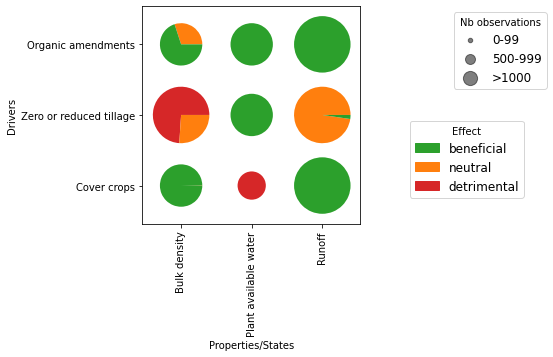

In [6]:
# simplified bubble chart
pracs = {
    'Cover crops': ['Cover crop'],
    'Zero or reduced tillage': ['No-till', 'Reduced till'],
    'Organic amendments': ['Biochar', 'Organic amendment', 'Mulch'],
}
varias = {
    'Bulk density': ['Bulk density'],
    'Plant available water': ['Available water capacity'],
    'Runoff': ['Runoff'],    
}
repcol = 'Nb ES'
efcol = 'Assumed effect'
table = []
fig, ax = plt.subplots(figsize=(6, 4))
colors = {1: 'tab:green', 0: 'tab:orange', -1: 'tab:red'}
patches = []
for i, prac in enumerate(pracs):
    for j, varia in enumerate(varias):
        ie = dfvar['Practice'].isin(pracs[prac]) & dfvar['Variable'].isin(varias[varia]) & dfvar[efcol].notnull()
        if ie.sum() > 0:
            # size of the circle
            nES = dfvar[ie][repcol].sum()
            r = 0
            if nES < 100:
                r = 2
            elif nES < 1000:
                r = 3
            elif nES > 1000:
                r = 4
            theta1 = 0

            # section of the circle (wedges, one per statistical group)
            sdf = dfvar[ie].groupby(efcol).sum().reset_index()  # group by statistical impact
            sumES = sdf[repcol].sum()
            sdf[repcol] = sdf[repcol]/sumES  # proportion for each statistical impact group
            if sdf[repcol].isna().sum() > 0:
                print('NaN in Nb ES column')
                #print(prac, varia, sdf)
                sdf[repcol] = sdf[repcol].fillna(0)
            #print(prac, varia, ie.sum(), nES)
            #display(sdf[['Statistical impact', 'Nb ES']])
            for k in range(sdf.shape[0]):
                theta2 = theta1 + sdf.loc[k, repcol]*360
                #print(theta2, j, i, r, colors[sdf.loc[k, 'Statistical impact']])
                ax.add_patch(mpatches.Wedge((j, i), r*0.1, theta1, theta2, ec='none',
                                            color=colors[sdf.loc[k, efcol]]))
                theta1 = theta2
                table.append([prac, varia, int(sdf.loc[k, repcol]*sumES), sdf.loc[k, efcol]])

ax.set_aspect('equal')
ax.set_yticks(np.arange(len(pracs.keys())))
ax.set_yticklabels(list(pracs.keys()))
ax.set_xticks(np.arange(len(varias.keys())))
ax.set_xticklabels(list(varias.keys()), rotation=90)
ax.set_xlabel('Properties/States')
ax.set_ylabel('Drivers')

# add the legend
msizes = [100, 500, 1000]
labels = ['0-99', '500-999', '>1000']
markers = []
for i, size in enumerate(msizes):
    markers.append(plt.scatter([],[], s=size*0.2, label=labels[i], color='k', alpha=0.5))
ax.add_artist(plt.legend(handles=markers, bbox_to_anchor=(1.4, 1), title='Nb observations', fontsize=12))

markers = []
markers.append(ax.add_patch(mpatches.Wedge((0,0), 0, 0, 360, color=colors[1], label='beneficial')))
markers.append(ax.add_patch(mpatches.Wedge((0,0), 0, 0, 360, color=colors[0], label='neutral')))
markers.append(ax.add_patch(mpatches.Wedge((0,0), 0, 0, 360, color=colors[-1], label='detrimental')))
ax.legend(handles=markers, bbox_to_anchor=(1.2, 0.5), title='Effect', fontsize=12)

# create table
table = pd.DataFrame(table, columns=['driver', 'variable', 'observations', 'effect'])
table['effect'] = table['effect'].replace({1: 'beneficial', 0: 'neutral', -1: 'detrimental'})
table.to_csv(outputdir + 'table-simple-bubble.csv', index=False)
display(table)

fig.savefig(outputdir + 'impact-simple-bubble.jpg', bbox_inches='tight', dpi=500)

maybe do 3 graphs for positive, negative or neutral or just take mean?

## Quality assessement (Beillouin et al. criteria)

In [7]:
# list of columns to include
bcols = [
    'The list of included studies is provided',
    'Inclusion and exclusion criteria are mentionned',
    'The aim of the study is clearly mentionned',
#    'Additional literature search is performed',
    'Literature databases are mentionned', 'Search strings are presented',
    'The number of studies is given at each selection steps',
    'The list of excluded studies is provided',
    'Quantitative results of the meta-analysis are fully described',
#    'All tools used for the review are mentioned',
#    'Statistical models are described',
    'Effect sizes of individuals studies are presented',
#    'Studies are weighted according to their accuracy',
    'The dataset is available', 'Method of data extraction is described',
    'Heterogeneity of results is analysed',
    'Funding sources are mentionned', 'Publication bias is analysed',
    'A protocol is published before the meta-analysis'
]

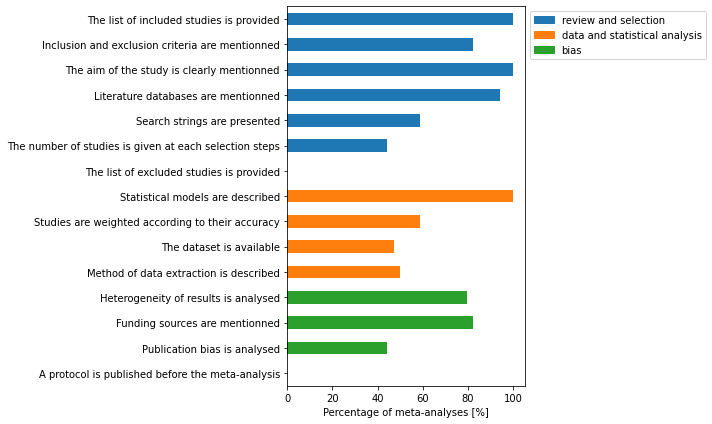

In [8]:
df = dfmeta
bcols = df.columns[17:36]
# remove criteria that were not clear
bcols = bcols[np.array([True, True, True, False, True, True, True, True, False, False, 
               True, False, True, True, True, True, True, True, True])]

n = df.shape[0]
fig, ax = plt.subplots(figsize=(10, 6))
y = df[bcols].eq('yes').sum(axis=0)/n*100
y.plot.barh(ax=ax, color=['C0']*7 + ['C1']*4 + ['C2']*4)
ax.invert_yaxis()
ax.set_xlabel('Percentage of meta-analyses [%]')

# add legend
blue_patch = mpatches.Patch(color='tab:blue', label='review and selection')
orange_patch = mpatches.Patch(color='tab:orange', label='data and statistical analysis')
green_patch = mpatches.Patch(color='tab:green', label='bias')
ax.legend(handles=[blue_patch, orange_patch, green_patch], bbox_to_anchor=[1, 1])

fig.tight_layout()
fig.savefig(outputdir + 'quality-beillouin.jpg', dpi=500)